# Chapter 10: Logistic Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition)
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

!pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=56982dc84bc324fccdae71ff517452d22037e18d07b56cf7020241fd57a3faf3
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 16.8 MB/s eta 0:00:00
Colab environment detected.


## Universal Bank
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [ ]:
bank = pd.read_csv("UniversalBank.csv")
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
bank.drop(columns=['ID','ZIP Code'], inplace=True)

In [ ]:
bank.columns = [c.replace(' ','_') for c in bank.columns]

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal_Loan       5000 non-null   int64  
 8   Securities_Account  5000 non-null   int64  
 9   CD_Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


In [ ]:
#create new categories for education 1-3
bank['Education'] = bank['Education'].astype('category')
new_categories = {1: 'undergrad', 2: 'graduate', 3: 'professional'}
bank.Education.cat.rename_categories(new_categories, inplace=True)


<ipython-input-9-8b9f34c88a40>:4: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  bank.Education.cat.rename_categories(new_categories, inplace=True)


In [ ]:
bank.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,undergrad,0,0,1,0,0,0
1,45,19,34,3,1.5,undergrad,0,0,1,0,0,0
2,39,15,11,1,1.0,undergrad,0,0,0,0,0,0
3,35,9,100,1,2.7,graduate,0,0,0,0,0,0
4,35,8,45,4,1.0,graduate,0,0,0,0,0,1


In [ ]:
bank = pd.get_dummies(bank, prefix_sep='_', drop_first=True) #we dropped undergrad
bank.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_graduate,Education_professional
0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,1,0



## Universal bank probabilities
Predict to get the probabilities

In [ ]:
X = bank.drop(columns='Personal_Loan')
y = bank['Personal_Loan'] #we predict PL

train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.4, random_state=1)

In [ ]:
#Demo Code Insert 1
logit_reg = LogisticRegression(solver = 'liblinear', C=1e42, random_state=1)  # solver more than 2 predictions; C= 1 if the dataset is a full representative or not - normalization coefficent
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
logit_reg.intercept_ #this doesn't make sense becuase coefficent P has to be bet 0-1

array([-12.49343606])

In [ ]:
logit_reg.coef_  #equation: logit(P)= -12 + -.03 X1 + .6X2....

array([[-3.76845180e-02,  3.92022512e-02,  5.88441043e-02,
         6.12250855e-01,  2.40489188e-01,  1.01185034e-03,
        -1.01427976e+00,  3.64909684e+00, -6.78305647e-01,
        -9.58282919e-01,  4.20214845e+00,  4.35576095e+00]])

In [ ]:
 pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns) #we create a dataframe; show the coef with variable names

,coef
Age,-0.037685
Experience,0.039202
Income,0.058844
Family,0.612251
CCAvg,0.240489
Mortgage,0.001012
Securities_Account,-1.014280
CD_Account,3.649097
Online,-0.678306
CreditCard,-0.958283


In [ ]:
#create a table of probabilities and predictions
logit_reg_prob = logit_reg.predict_proba(valid_X)
logit_reg_prob

array([[9.76092107e-01, 2.39078935e-02],
       [9.99936884e-01, 6.31156129e-05],
       [9.99900271e-01, 9.97287075e-05],
       ...,
       [9.99789886e-01, 2.10113937e-04],
       [9.98459391e-01, 1.54060920e-03],
       [9.92781729e-01, 7.21827111e-03]])

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X) #pred proba is lot more useful; a lot more flexible

In [ ]:
logit_result = pd.DataFrame({'actual': valid_y,
                            'p_0': [p[0] for p in logit_reg_prob],
                            'p_1': [p[1] for p in logit_reg_prob],
                            'predicted': logit_reg_pred}) #first column - actual values; second - prob of a 0, third - prob of 1, last column - predicted
logit_result

,actual,p_0,p_1,predicted
2764,0,0.976092,0.023908,0
4767,0,0.999937,0.000063,0
3814,0,0.999900,0.000100,0
3499,0,0.998398,0.001602,0
2735,0,0.957211,0.042789,0
...,...,...,...,...
4372,0,0.996236,0.003764,0
3401,0,0.999644,0.000356,0
1239,0,0.999790,0.000210,0
437,0,0.998459,0.001541,0


In [ ]:
#we use classification summary
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 2683   30
     1   90  197


In [ ]:
classificationSummary(valid_y, logit_reg.predict(valid_X))  #we have a very unbalanced dataset; model is not overfit, if overfit, we drop some variables

Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


## Universal Bank Gains Chart

In [ ]:
#create quick dataframe arranged in ascending order
df = logit_result.sort_values(by = ['p_1'], ascending=False)
df

,actual,p_0,p_1,predicted
3373,1,0.000570,0.999430,1
2217,1,0.000877,0.999123,1
787,1,0.001024,0.998976,1
47,1,0.002322,0.997678,1
3006,1,0.002460,0.997540,1
...,...,...,...,...
1100,0,0.999997,0.000003,0
4922,0,0.999997,0.000003,0
1720,0,0.999997,0.000003,0
3125,0,0.999998,0.000002,0


<Axes: title={'center': 'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

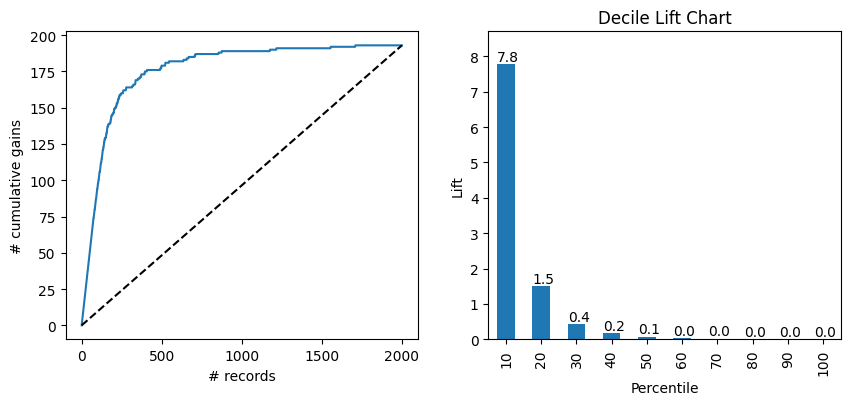

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4)) #we are creating gains chart on left, lift chart on righ
gainsChart(df.actual, ax=axes[0])
liftChart(df['p_1'], ax=axes[1])

In [ ]:
#lift chart: slpit into 10 buckets; the top 10% is 7.8 times more likely to get the loan
#gain chart: the bigger the bend, the better; the x #of recrods, y cum gains (# of yeses); diagnoal line is random; 500 of records gives me 180 yeses

## Flight Delays

In [ ]:
delays = pd.read_csv('FlightDelays.csv')
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [ ]:
#another way to create dummies; if we have more than 2 categories, we just continue the loop
delays['isdelayed'] = [1 if a == 'delayed' else 0 for a in delays['Flight Status']]
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,isdelayed
0,15,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,16,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,12,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,17,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,0
4,10,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,0


In [ ]:
delays.DAY_WEEK= delays.DAY_WEEK.astype('category') #we create categories

In [ ]:
delays.CRS_DEP_TIME = [round(t/100) for t in delays.CRS_DEP_TIME]
delays.CRS_DEP_TIME = delays.CRS_DEP_TIME.astype('category')
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,isdelayed
0,15,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,16,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,12,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,17,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,0
4,10,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,0


In [ ]:
predictors = ['CRS_DEP_TIME', 'DAY_WEEK', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'isdelayed'

In [ ]:
X=pd.get_dummies(delays[predictors], drop_first=True)
y=delays[outcome]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   CRS_DEP_TIME_7   2201 non-null   uint8
 1   CRS_DEP_TIME_8   2201 non-null   uint8
 2   CRS_DEP_TIME_9   2201 non-null   uint8
 3   CRS_DEP_TIME_10  2201 non-null   uint8
 4   CRS_DEP_TIME_11  2201 non-null   uint8
 5   CRS_DEP_TIME_12  2201 non-null   uint8
 6   CRS_DEP_TIME_13  2201 non-null   uint8
 7   CRS_DEP_TIME_14  2201 non-null   uint8
 8   CRS_DEP_TIME_15  2201 non-null   uint8
 9   CRS_DEP_TIME_16  2201 non-null   uint8
 10  CRS_DEP_TIME_17  2201 non-null   uint8
 11  CRS_DEP_TIME_18  2201 non-null   uint8
 12  CRS_DEP_TIME_19  2201 non-null   uint8
 13  CRS_DEP_TIME_20  2201 non-null   uint8
 14  CRS_DEP_TIME_21  2201 non-null   uint8
 15  DAY_WEEK_2       2201 non-null   uint8
 16  DAY_WEEK_3       2201 non-null   uint8
 17  DAY_WEEK_4       2201 non-null   uint8
 18  DAY_WEEK

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.4, random_state=1)

In [ ]:
#Demo Code Insert 2
log_reg = LogisticRegression(random_state=1, solver= 'liblinear', C=1e42)
log_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
log_reg.intercept_

array([-1.11680637])

In [ ]:
log_reg.coef_

array([[ 0.61996524,  0.38463444, -0.16830178,  0.43908682,  0.05524829,
         0.48504307,  0.18334836,  0.32913864,  1.31953784,  0.6677276 ,
         1.12152758,  0.27708007,  1.68013715,  1.00947245,  1.13306024,
        -0.48059736, -0.79187063, -0.89050069, -0.38529708, -1.21498115,
        -0.18865326, -0.10088941, -0.1741141 , -0.44872699, -0.46406568,
         0.28624744, -0.70845772,  0.7262028 , -0.92781232, -0.23447774,
         0.50923929, -1.06543532]])

In [ ]:
pd.DataFrame({'coef': log_reg.coef_[0], 'variable': X.columns})

,coef,variable
0,0.619965,CRS_DEP_TIME_7
1,0.384634,CRS_DEP_TIME_8
2,-0.168302,CRS_DEP_TIME_9
3,0.439087,CRS_DEP_TIME_10
4,0.055248,CRS_DEP_TIME_11
5,0.485043,CRS_DEP_TIME_12
6,0.183348,CRS_DEP_TIME_13
7,0.329139,CRS_DEP_TIME_14
8,1.319538,CRS_DEP_TIME_15
9,0.667728,CRS_DEP_TIME_16


In [ ]:
#to do the Odds ratio
pd.DataFrame({'coef': log_reg.coef_[0], 'odds': np.e**log_reg.coef_[0], 'variable': X.columns})
#85% times likely to be on than at 7am vs  6am; 9am is the most ontime flight
#compare it to noon, we would not drop first instead drop cRS DEP Time 12 noon; Sunday day week 7 - .16 to be delayed (.82 - 1)

,coef,odds,variable
0,0.619965,1.858863,CRS_DEP_TIME_7
1,0.384634,1.469077,CRS_DEP_TIME_8
2,-0.168302,0.845099,CRS_DEP_TIME_9
3,0.439087,1.551290,CRS_DEP_TIME_10
4,0.055248,1.056803,CRS_DEP_TIME_11
5,0.485043,1.624245,CRS_DEP_TIME_12
6,0.183348,1.201233,CRS_DEP_TIME_13
7,0.329139,1.389771,CRS_DEP_TIME_14
8,1.319538,3.741692,CRS_DEP_TIME_15
9,0.667728,1.949802,CRS_DEP_TIME_16


In [ ]:
log_reg_prob = log_reg.predict_proba(valid_X)
log_reg_pred = log_reg.predict(valid_X)

In [ ]:
log_result = pd.DataFrame({'actual': valid_y,
                            'p_0': [p[0] for p in log_reg_prob],
                            'p_1': [p[1] for p in log_reg_prob],
                            'predicted': log_reg_pred}) #first column - actual values; second - prob of a 0, third - prob of 1, last column - predicted
log_result

,actual,p_0,p_1,predicted
1276,0,0.686901,0.313099,0
1446,0,0.960155,0.039845,0
335,0,0.805467,0.194533,0
1458,0,0.948094,0.051906,0
2038,0,0.966451,0.033549,0
...,...,...,...,...
460,0,0.812663,0.187337,0
2063,0,0.903135,0.096865,0
159,0,0.824281,0.175719,0
2027,1,0.953369,0.046631,0


In [ ]:
classes = ['ontime', 'delayed']
classificationSummary(log_result.actual, log_result.predicted, class_names=classes) #model could be biased as there are more on the ontime - not balanced

Confusion Matrix (Accuracy 0.8093)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     159       8


<Axes: xlabel='# records', ylabel='# cumulative gains'>

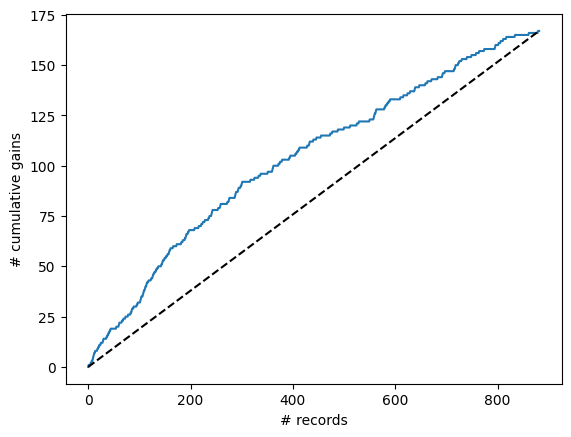

In [ ]:
log_result = log_result.sort_values(by='p_1', ascending=False) #if we get a ROC that is below the diagonal line, we didnt'sort it.
gainsChart(log_result.actual) #this what happens when we don't sort our data

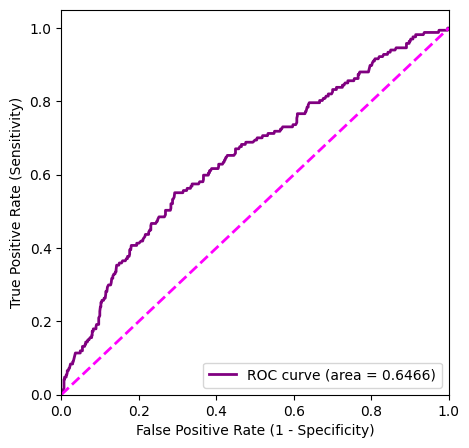

In [ ]:
fpr, tpr, _ = roc_curve(log_result['actual'], log_result['p_1'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, color='purple',
 lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='magenta', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

#same as the gains chart; changed labels in the axis

### Multinomial Nominal logistic regression

In [2]:
data=pd.read_csv('accidentsFull.csv')
data.head()

,HOUR_I_R,ALCHL_I,ALIGN_I,STRATUM_R,WRK_ZONE,WKDY_I_R,INT_HWY,LGTCON_I_R,MANCOL_I_R,PED_ACC_R,...,SUR_COND,TRAF_CON_R,TRAF_WAY,VEH_INVL,WEATHER_R,INJURY_CRASH,NO_INJ_I,PRPTYDMG_CRASH,FATALITIES,MAX_SEV_IR
0,0,2,2,1,0,1,0,3,0,0,...,4,0,3,1,1,1,1,0,0,1
1,1,2,1,0,0,1,1,3,2,0,...,4,0,3,2,2,0,0,1,0,0
2,1,2,1,0,0,1,0,3,2,0,...,4,1,2,2,2,0,0,1,0,0
3,1,2,1,1,0,0,0,3,2,0,...,4,1,2,2,1,0,0,1,0,0
4,1,1,1,0,0,1,0,3,2,0,...,4,0,2,3,1,0,0,1,0,0


In [3]:
data.ALCHL_I=data.ALCHL_I.astype('category')
data.WEATHER_R=data.WEATHER_R.astype('category')
data.WRK_ZONE=data.WRK_ZONE.astype('category')
#Best practice is to convert your target to category, but it is not required. especially when values are not 0 1
#data.MAX_SEV_IR=data.MAX_SEV_IR.astype('category')

In [4]:
predictors = ['ALCHL_I', 'WEATHER_R', 'WRK_ZONE', 'SPD_LIM', 'VEH_INVL']
outcome = 'MAX_SEV_IR'

In [5]:
X=pd.get_dummies(data[predictors], drop_first=True)
y=data[outcome]

In [6]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=.4, random_state=1)

In [ ]:
#Demo Code Insert 3

In [8]:
#There is no need to change C because it is multinomial
logit = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial', C=1, max_iter=1000) #lbfgs for multiple events; 1 for C
logit.fit(train_X, train_y)  #model is not converging if without max_iter

LogisticRegression(C=1, max_iter=1000, multi_class='multinomial',
                   random_state=1)

In [10]:
log_reg_prob

array([[0.48145102, 0.50351856, 0.01503041],
       [0.48264644, 0.50627705, 0.0110765 ],
       [0.48367397, 0.51191652, 0.00440951],
       ...,
       [0.5249652 , 0.46490573, 0.01012906],
       [0.48333337, 0.50851255, 0.00815408],
       [0.415039  , 0.55620025, 0.02876075]])

In [18]:
log_reg_pred = logit.predict(valid_X)
log_reg_prob = logit.predict_proba(valid_X)
log_result = pd.DataFrame({'actual': valid_y, 'predicted': log_reg_pred, 'p_0': [p[0] for p in log_reg_prob],
                                                                        'p_1':  [p[1] for p in log_reg_prob],
                                                                        'p_2':  [p[2] for p in log_reg_prob]})
log_result #highest p2; one that predict severity P_0 if there was an accident

,actual,predicted,p_0,p_1,p_2
24895,1,1,0.481451,0.503519,0.015030
5306,0,1,0.482646,0.506277,0.011077
21954,0,1,0.483674,0.511917,0.004410
37948,1,1,0.483643,0.510359,0.005998
39072,0,1,0.483643,0.510359,0.005998
...,...,...,...,...,...
20008,0,1,0.483333,0.508513,0.008154
40905,0,0,0.525359,0.465949,0.008691
40952,1,0,0.524965,0.464906,0.010129
18454,0,1,0.483333,0.508513,0.008154


In [19]:
logit.coef_ #we can't interpret this as normal odds ratio;

array([[-0.0101582 ,  0.13970093,  0.51348082,  0.4759005 , -0.033445  ],
       [-0.01045656,  0.31645695,  0.09773579,  0.24345011, -0.05509796],
       [ 0.02061475, -0.45615788, -0.61121661, -0.71935061,  0.08854296]])

In [26]:
#not necessary anymore
pred = pd.DataFrame({'predicted': logit.predict(valid_X)})
pred

,predicted
0,1
1,1
2,1
3,1
4,1
...,...
16869,1
16870,0
16871,0
16872,1


In [24]:
#classification summary; not a good model; could be because we are splitting our accuracy; model even didn't predict P_2
classificationSummary(valid_y, pred)

Confusion Matrix (Accuracy 0.4980)

       Prediction
Actual    0    1    2
     0 2804 5525    0
     1 2755 5599    0
     2   77  114    0


In [25]:
#other way
classificationSummary(valid_y, logit.predict(valid_X))

Confusion Matrix (Accuracy 0.4980)

       Prediction
Actual    0    1    2
     0 2804 5525    0
     1 2755 5599    0
     2   77  114    0
